# Streamlining workflows with pipelines

1-Obtaining the Breast Cancer Wisconsin dataset

In [21]:
import pandas as pd
df = pd.read_csv(
 'https://archive.ics.uci.edu/ml/'
 'machine-learning-databases'
 '/breast-cancer-wisconsin/wdbc.data',
 header=None)

2-Next, we will assign the 30 features to a NumPy array, X. Using
a LabelEncoder object, we will transform the class labels from their
original string representation ('M' and 'B') into integers:

In [22]:
from sklearn.preprocessing import LabelEncoder

X=df.loc[:, 2:].values
y=df.loc[:, 1].values
le=LabelEncoder()
y=le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [23]:
le.transform(['M', 'B'])

array([1, 0])

3-train and test split

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

Instead of going through the model fitting and data transformation steps for the
training and test datasets separately, we can chain the StandardScaler, PCA,
and LogisticRegression objects in a pipeline:

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
pipe_lr=make_pipeline(StandardScaler(),
                      PCA(n_components=2),
                          LogisticRegression(random_state=1,
                                             solver='lbfgs'))
pipe_lr.fit(X_train, y_train)
y_pred=pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.956


# Using k-fold cross-validation to assess model performance

##holdout cross-validation

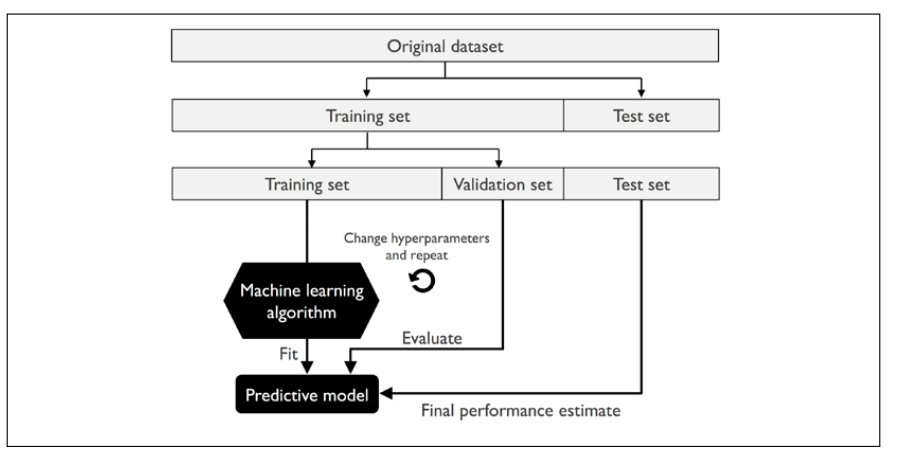

##K-fold cross-validation

In [26]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold=StratifiedKFold(n_splits=10).split(X_train, y_train)
scores=[]
for k, (train, test) in enumerate(kfold):
  pipe_lr.fit(X_train[train], y_train[train])
  score = pipe_lr.score(X_train[test], y_train[test])
  scores.append(score)
  print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))


Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [27]:
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))


CV accuracy: 0.950 +/- 0.014


In [28]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(estimator=pipe_lr,
                       X=X_train,
                       y=y_train,
                       cv=10,
                       n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


An extremely useful feature of the cross_val_score approach is that we can
distribute the evaluation of the different folds across multiple central processing
units (CPUs) on our machine. If we set the n_jobs parameter to 1, only one CPU
will be used to evaluate the performances, just like in our StratifiedKFold example
previously. However, by setting n_jobs=2, we could distribute the 10 rounds
of cross-validation to two CPUs (if available on our machine), and by setting
n_jobs=-1, we can use all available CPUs on our machine to do the computation
in parallel.


# Debugging algorithms with learning and validation curves

Diagnosing bias and variance problems with **learning curves**

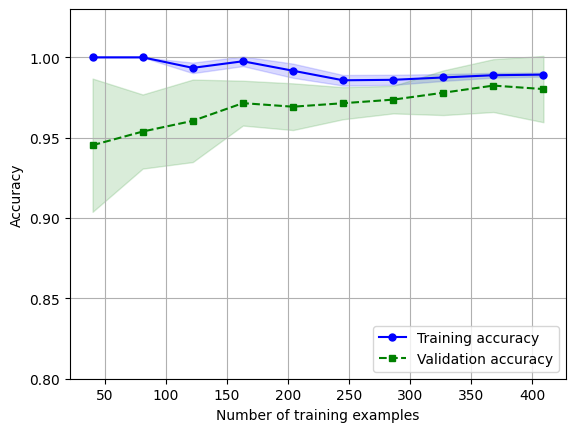

In [29]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=1, solver='lbfgs', max_iter=10000))

train_size, train_scores, test_scores=learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     cv=10,
                                                     n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_size, train_mean, color='blue',marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_size, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_size, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_size, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

In [30]:
train_size

array([ 40,  81, 122, 163, 204, 245, 286, 327, 368, 409])

Addressing over- and underfitting with **validation curves**

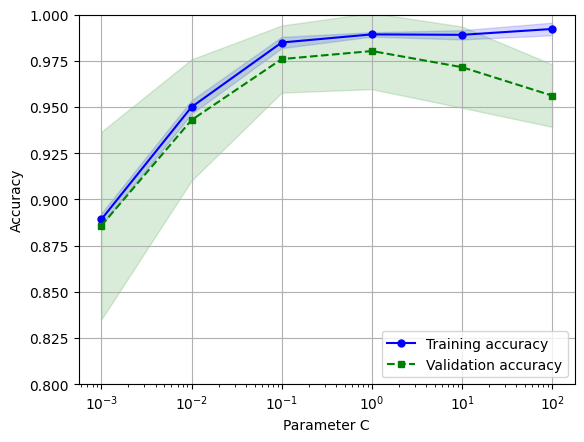

In [31]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
    color='blue', marker='o',
    markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')

plt.plot(param_range, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=5,
    label='Validation accuracy')
plt.fill_between(param_range,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()


# Fine-tuning machine learning models via grid search

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc=make_pipeline(StandardScaler(), SVC(random_state=1))

param_range= [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid= [{'svc__C': param_range, 'svc__kernel': ['linear']}, {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]
gs=GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                scoring='accuracy',
                cv=10,
                refit=True,
                n_jobs=-1)

gs=gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [36]:
clf=gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974
